In [46]:
import tensorflow as tf
from tensorflow import keras

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network.
But what happens when you have more than two classes?

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple,
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [47]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the
data.

We have 8,982 training examples and 2,246 test examples:

In [48]:
len(train_data)

8982

In [49]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [50]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [51]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [52]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [53]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [54]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot"
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding".
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1.
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [55]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [56]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the
dimensionality of the output space is much larger.

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer.
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks,
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [57]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions:
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [58]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [59]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [60]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 77ms/step - loss: 2.7597 - accuracy: 0.4350 - val_loss: 1.8647 - val_accuracy: 0.6050
Epoch 2/20
16/16 [==============================] - 1s 45ms/step - loss: 1.5756 - accuracy: 0.6756 - val_loss: 1.4059 - val_accuracy: 0.6760
Epoch 3/20
16/16 [==============================] - 1s 46ms/step - loss: 1.2048 - accuracy: 0.7400 - val_loss: 1.1890 - val_accuracy: 0.7440
Epoch 4/20
16/16 [==============================] - 1s 45ms/step - loss: 0.9815 - accuracy: 0.7883 - val_loss: 1.0809 - val_accuracy: 0.7580
Epoch 5/20
16/16 [==============================] - 1s 44ms/step - loss: 0.8152 - accuracy: 0.8237 - val_loss: 1.0170 - val_accuracy: 0.7870
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.6781 - accuracy: 0.8524 - val_loss: 0.9702 - val_accuracy: 0.7840
Epoch 7/20
16/16 [==============================] - 1s 43ms/step - loss: 0.5708 - accuracy: 0.8767 - val_loss: 0.9536 - val_accuracy: 0.7950
Epoch 8/20
16

Let's display its loss and accuracy curves:

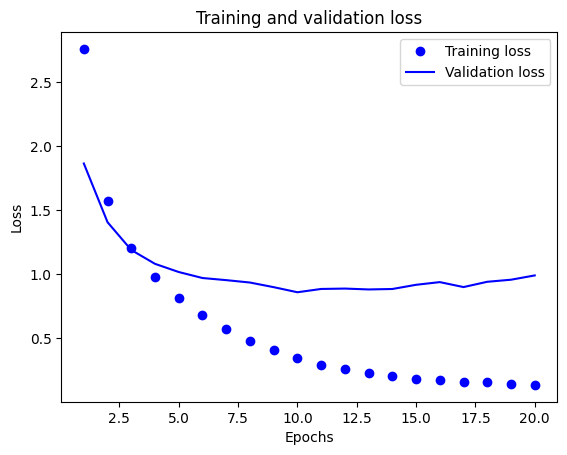

In [61]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss_orig = val_loss

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

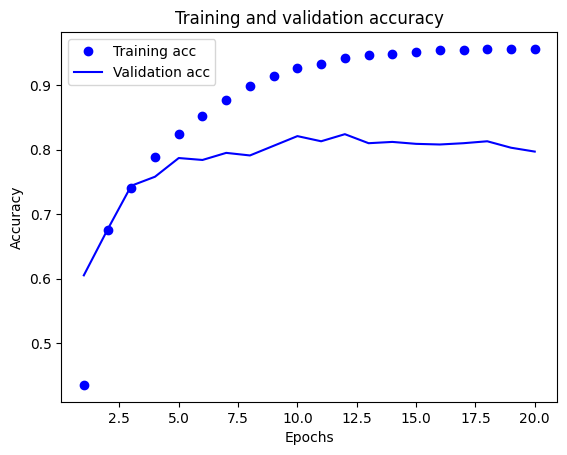

In [63]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_acc_orig = val_acc

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on
the test set:

In [64]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 1s 65ms/step - loss: 2.5522 - accuracy: 0.5353 - val_loss: 1.6998 - val_accuracy: 0.6330
Epoch 2/8
16/16 [==============================] - 1s 51ms/step - loss: 1.4590 - accuracy: 0.6887 - val_loss: 1.3199 - val_accuracy: 0.6970
Epoch 3/8
16/16 [==============================] - 1s 46ms/step - loss: 1.1353 - accuracy: 0.7473 - val_loss: 1.1669 - val_accuracy: 0.7310
Epoch 4/8
16/16 [==============================] - 1s 47ms/step - loss: 0.9326 - accuracy: 0.7938 - val_loss: 1.0565 - val_accuracy: 0.7610
Epoch 5/8
16/16 [==============================] - 1s 48ms/step - loss: 0.7797 - accuracy: 0.8285 - val_loss: 0.9869 - val_accuracy: 0.7940
Epoch 6/8
16/16 [==============================] - 1s 45ms/step - loss: 0.6495 - accuracy: 0.8558 - val_loss: 0.9483 - val_accuracy: 0.7980
Epoch 7/8
16/16 [==============================] - 1s 57ms/step - loss: 0.5452 - accuracy: 0.8817 - val_loss: 0.9093 - val_accuracy: 0.8100
Epoch 8/8
71/71 [===

In [65]:
results

[0.968705952167511, 0.7756010890007019]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [66]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19456812110418523

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic
predictions for all of the test data:

In [67]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


Each entry in `predictions` is a vector of length 46:

In [68]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [69]:
np.sum(predictions[0])

0.9999999

The largest entry is the predicted class, i.e. the class with the highest probability:

In [70]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [71]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [72]:
print(y_train)

[ 3  4  3 ... 25  3 25]



The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [73]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than
46-dimensional, e.g. 4-dimensional.

In [74]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 2.8961 - accuracy: 0.4024 - val_loss: 2.1708 - val_accuracy: 0.5380
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 1.8466 - accuracy: 0.6069 - val_loss: 1.6572 - val_accuracy: 0.5990
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 1.5011 - accuracy: 0.6369 - val_loss: 1.4895 - val_accuracy: 0.6250
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 1.3452 - accuracy: 0.6517 - val_loss: 1.4334 - val_accuracy: 0.6300
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 1.2439 - accuracy: 0.6639 - val_loss: 1.3855 - val_accuracy: 0.6380
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 1.1455 - accuracy: 0.6901 - val_loss: 1.3347 - val_accuracy: 0.6630
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 1.0506 - accuracy: 0.7108 - val_loss: 1.2946 - val_accuracy: 0.6780
Epoch 8/20
63


Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all
of it.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having
intermediate layers that are too small.

# **Problem 6 with 1 Layer**

In [75]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
16/16 [==============================] - 2s 99ms/step - loss: 2.6028 - accuracy: 0.5445 - val_loss: 1.8273 - val_accuracy: 0.6370
Epoch 2/20
16/16 [==============================] - 1s 47ms/step - loss: 1.5304 - accuracy: 0.6977 - val_loss: 1.3786 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 1s 45ms/step - loss: 1.1572 - accuracy: 0.7608 - val_loss: 1.1759 - val_accuracy: 0.7610
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 0.9406 - accuracy: 0.8034 - val_loss: 1.0524 - val_accuracy: 0.7830
Epoch 5/20
16/16 [==============================] - 1s 45ms/step - loss: 0.7858 - accuracy: 0.8349 - val_loss: 0.9822 - val_accuracy: 0.7840
Epoch 6/20
16/16 [==============================] - 1s 45ms/step - loss: 0.6667 - accuracy: 0.8644 - val_loss: 0.9199 - val_accuracy: 0.8020
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5698 - accuracy: 0.8859 - val_loss: 0.8781 - val_accuracy: 0.8130
Epoch 8/20
16

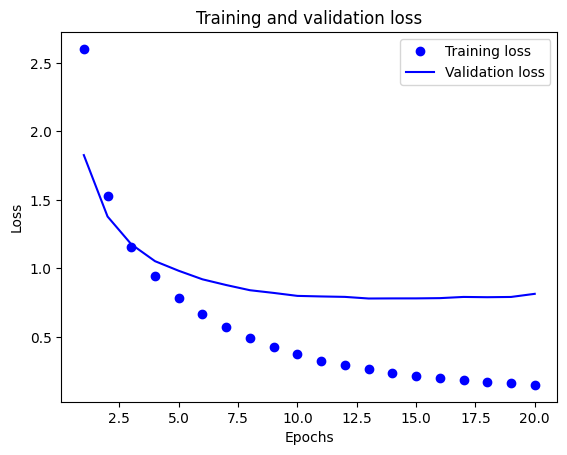

In [76]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss1 = val_loss

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

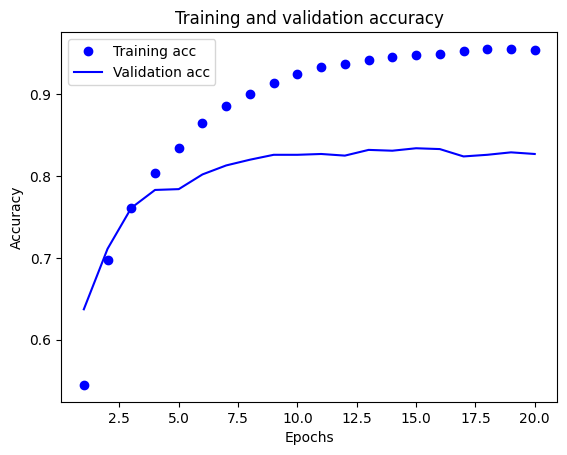

In [77]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_acc1 = val_acc

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **Problem 6 with 3 hidden layers**

In [78]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu')) ##Additional Hidden Layer
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 152ms/step - loss: 2.7378 - accuracy: 0.4328 - val_loss: 1.8123 - val_accuracy: 0.5910
Epoch 2/20
16/16 [==============================] - 2s 116ms/step - loss: 1.5698 - accuracy: 0.6434 - val_loss: 1.4088 - val_accuracy: 0.6670
Epoch 3/20
16/16 [==============================] - 1s 90ms/step - loss: 1.2422 - accuracy: 0.7176 - val_loss: 1.2214 - val_accuracy: 0.7170
Epoch 4/20
16/16 [==============================] - 1s 51ms/step - loss: 1.0229 - accuracy: 0.7697 - val_loss: 1.1222 - val_accuracy: 0.7400
Epoch 5/20
16/16 [==============================] - 1s 50ms/step - loss: 0.8656 - accuracy: 0.8044 - val_loss: 1.0423 - val_accuracy: 0.7600
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.7101 - accuracy: 0.8391 - val_loss: 1.0791 - val_accuracy: 0.7680
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6023 - accuracy: 0.8662 - val_loss: 0.9552 - val_accuracy: 0.7940
Epoch 8/20


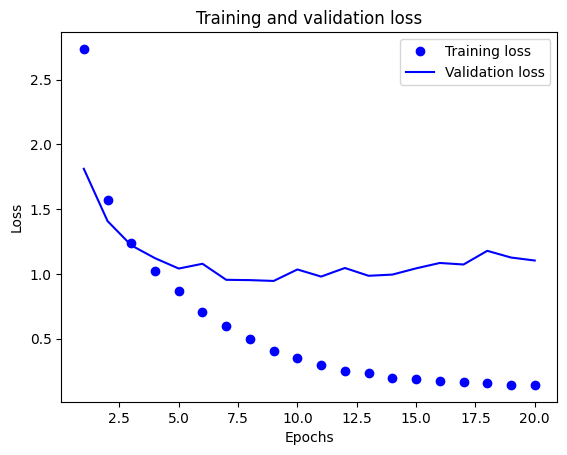

In [79]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss2 = val_loss

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

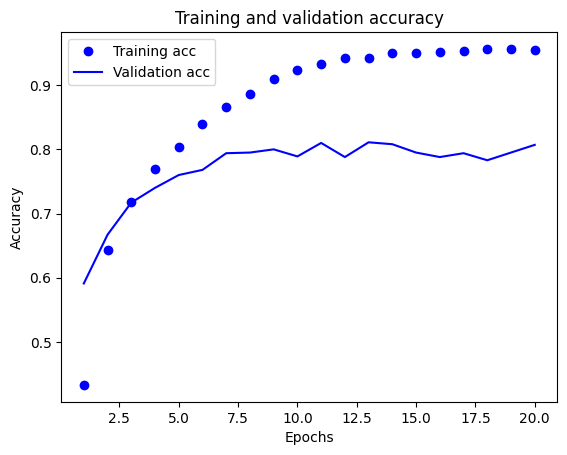

In [80]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_acc2=val_acc

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

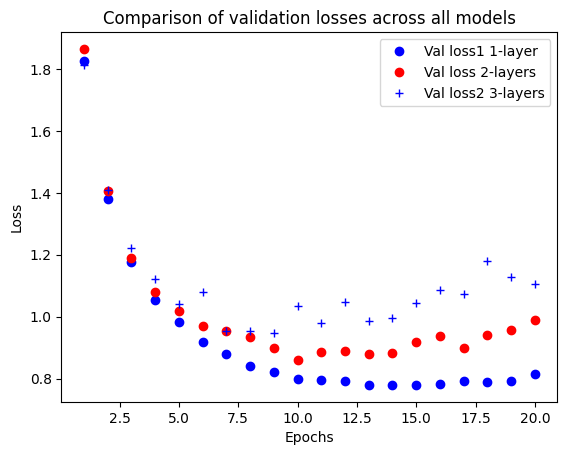

In [90]:
plt.clf()   # clear figure

import matplotlib.pyplot as plt



epochs = range(1, len(loss) + 1)

plt.plot(epochs, val_loss1, 'bo', label='Val loss1 1-layer')
plt.plot(epochs, val_loss_orig, 'ro', label='Val loss 2-layers')
plt.plot(epochs, val_loss2, 'b+', label='Val loss2 3-layers')

plt.title('Comparison of validation losses across all models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

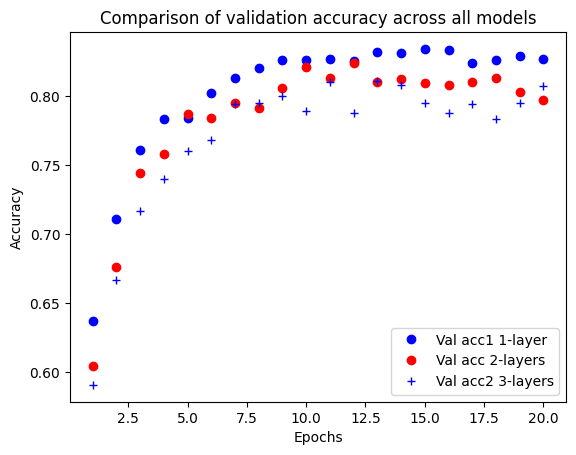

In [89]:
plt.clf()   # clear figure



plt.plot(epochs, val_acc1, 'bo', label='Val acc1 1-layer')
plt.plot(epochs, val_acc_orig, 'ro', label='Val acc 2-layers')
plt.plot(epochs, val_acc2, 'b+', label='Val acc2 3-layers')

plt.title('Comparison of validation accuracy across all models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## The loss is minimum at 13th epoch and then overfits for the 1-layer model.
## The loss is minimum at 10th epoch and then overfits for the 2-layer model.
## The loss is minimum at 9th epoch and then overfits for the 3-layer model.  
## So it is better to use 3 layer model and stopping at 9th epoch itself.